<a href="https://colab.research.google.com/github/PamePatzi/Sistema-inteligente-para-monitoreo-e-identificaci-n-temprana-de-melanoma/blob/main/ImplementacionDetectorMelanoma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import base64

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const stop = document.createElement('button');
      stop.textContent = 'Stop';
      //div.appendChild(stop);

      stop.addEventListener('click', function() {
          return '';
      });

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))

  print(data)
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  img = cv2.resize(img, (224, 244))
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

In [ ]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:


import gdown

url = 'https://drive.google.com/uc?id=1030MvMSnTFAHtCKhRcfzgby7ZPbCicH6'
output = '/content/my_model.zip'  # Specify the desired output file name and extension

gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1030MvMSnTFAHtCKhRcfzgby7ZPbCicH6
To: /content/my_model.zip
100%|██████████| 41.5M/41.5M [00:00<00:00, 161MB/s]


'/content/my_model.zip'

In [ ]:
import zipfile

zip_file_path = '/content/my_model.zip'  # Specify the path of the downloaded zip file
output_folder = '/content/'  # Specify the folder path where you want to extract the contents

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(output_folder)

In [ ]:
import shutil

model_path = '/content/content/drive/MyDrive//MelanomaDetector/my_model'
drive_folder_path = '/content/'  # Specify the folder path in Google Drive where you want to upload the model

shutil.move(model_path, drive_folder_path + 'my_model')

'/content/my_model'

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/my_model')

<IPython.core.display.Javascript object>


(480, 640)
Saved to photo.jpg

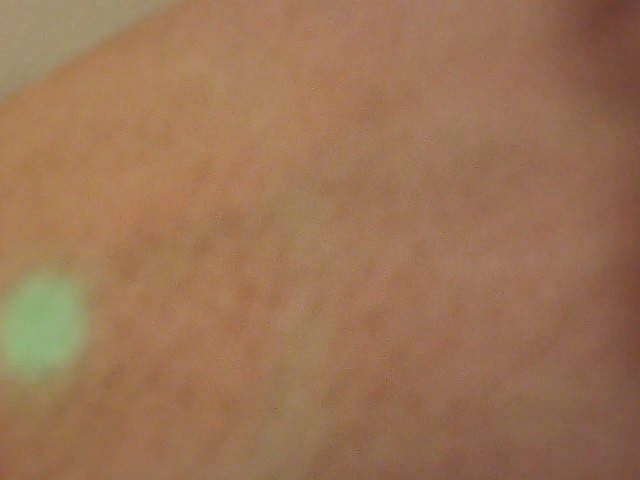

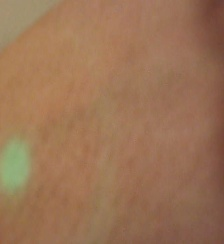

1/1 [==============================] - 0s 23ms/step
Predictions:
 1


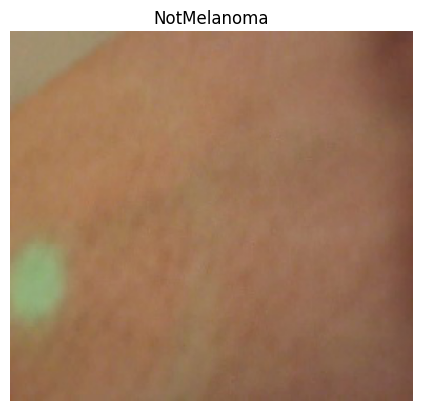

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  img = image.load_img('/content/photo.jpg', target_size=(224, 244))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = preprocess_input(img)

  
  # Show the image which was just taken.
  display(Image(filename))




  predictions = model.predict(img)
  

  predictions = np.exp(predictions) / np.sum(np.exp(predictions)) #softmax
  predictions = np.argmax(predictions)
  class_names = ['Melanoma', 'NotMelanoma']

  print('Predictions:\n', predictions)

  plt.figure()
  img = image.load_img('/content/photo.jpg', target_size=(224, 244))
  plt.imshow(img)
  plt.title(class_names[predictions])
  plt.axis("off")

except Exception as err:
  print(str(err)) 




1/1 [==============================] - 0s 24ms/step
